In [19]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

% matplotlib inline

## Question 1

### Data Loading

In [20]:
# Load the data from .txt file
data = []
with open('data1.txt', 'r') as file:
    line = file.readline()
    while line:
        data_str = line[:-1].split()
        for i in range(len(data_str)):
            try:
                data.append(float(data_str[i]))
            except:
                continue
        line = file.readline()

Visualize data distribution.

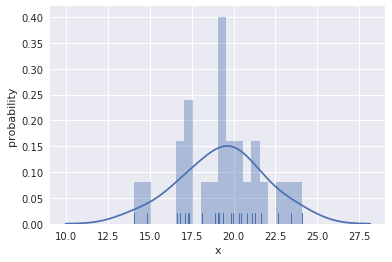

In [21]:
data = np.array(data).reshape(-1, 1)
hist = sns.distplot(data, bins=20, rug=True)
hist.set(xlabel='x', ylabel='probability')

### Part A: Parameter Estimation
  
With the sampled 25 data points, we hope to estimate mean $ \hat{\mu} $ and standard deviation $\hat{\sigma}$  under the assumption that the data was identically and independnetly sampled from a Gaussian distribution $N(\mu, \sigma ^ 2)$.

To obtain the estimation with iterative numerical method, I will use Maximum Likelihood Estimator (MLE) given the convex shape of log-likelihood function. In the following function, I will implement the newton-method for obtaining MLE estimation using Hassin Matrix, and a first-order gradient-based optimization method with momentum.

If we denote $x_1, x_2, ..., x_n$ be n iid samples and probability density of $X$ is $f(x; \theta)$ which depends on a vector $\theta = (\mu, \sigma ^ 2)$. Then the maximum likelihood estimate $\hat {\theta}$ is the value that maximizes the log-likelihood of the joint-probability distribution:

$$l(\theta)=\sum_{i=1}^{n}log[f(x_{i};\theta)]=-\frac{n}{2}log2\pi-\frac{n}{x}log\sigma^{2}-\frac{1}{2}\Sigma_{i=1}^{n}\frac{(x_{i}-\mu)^{2}}{\sigma^{2}}$$

Accroding to definition of Newton step:  $$\varDelta\theta=-(\frac{\partial^{2}l}{\partial\theta\partial\theta^{T}})^{-1}\frac{\partial l}{\partial t}$$

which is composed of gradient function and inverse of Hassian matrix .

From the defination of the objetive function, we could write the exact format of gradient function.

$$\frac{\partial f}{\partial\mu}=\sum_{i=1}^{n}\frac{(x_{i}-\mu)^{2}}{\sigma^{2}}$$

$$\frac{\partial f}{\partial\sigma^{2}}=-\frac{n}{2}\frac{1}{\sigma^{2}}+\frac{1}{2\sigma^{4}}\sum_{i=1}^{n}(x_{i}-\mu)^{2}$$



And Hessian Matrix:
$$H(\theta)=\left[\begin{array}{cc}
-\frac{n}{\sigma^{2}} & -\frac{1}{\sigma^{4}}\sum_{i=1}^{n}(x_{i}-\theta)\\
-\frac{1}{\sigma^{4}}\sum_{i=1}^{n}(x_{i}-\theta) & \frac{n}{2\sigma^{4}}-\frac{1}{\sigma^{4}}\sum_{i=1}^{n}(x_{i}-\theta)^2
\end{array}\right]$$

We could then iteratively updated $\theta$ with the computed $\varDelta\theta$ using the current parameter:$$\theta_{new}=\theta_{old}+\gamma\varDelta\theta$$

where $\gamma$ is the learning rate, we will go towards the optimum point.

In [4]:
def Gradient(x, theta):
    """
    Gradient of the Gaussia log-likelihood function over each parameter
    Args:
    x: array, n * 1, sample from the distribution
    theta: array, 2 * 1, current parameter for calculating the log-likelihood
    Return:
    grad: array, 2 * 1, gradient at current parameter
    """
    n = len(x)
    mu = theta[0]
    var = theta[1]
    grad = np.zeros((2,1))
    grad[0] = np.sum((x - mu))/var
    grad[1] = -1 * n / 2 / var + 1 / (2 * var ** 2) * np.sum((x - mu) ** 2)
    
    return grad

In [5]:
def Hassian(x, theta):
    """
    Hessian matrix of the Gaussia log-likelihood function
    Args:
    x: array, n * 1, sample from the distribution
    theta: array, 2 * 1, current parameter for calculating the log-likelihood
    Return:
    hassian: array, 2 * 2, Hessian matrix calculated with current paramter
    """
    hassian = np.zeros((2,2))
    n = len(x)
    mu = theta[0]
    var = theta[1]
    var2 = var ** 2
    var3 = var ** 3
    
    hassian[0][0] = -1 * n / var
    hassian[0][1] = -1 / (var2) * np.sum((x - mu))
    hassian[1][0] = -1 / (var2) * np.sum((x - mu))
    hassian[1][1] = n / (2 * var2) - 1 / (var3) * np.sum((x - mu) ** 2)
    
    return hassian

In [9]:
def Newton_MLE(data, theta_init, dtheta_mom_old=0, iteration=10000, lr=0.01, dead_count=10):
    """
    Compute maximum likelihood estimation using Newton Method
    Args:
    data: array, n * 1, sample from the distribution
    theta_init: array, 2 * 1, parameter initialization point, need to guarantee that Hassian matrix is negative definite
    tol: float, criteria for convergence
    lr: float, initial learning rate
    dead_count: int, number of iterations that reducing learning rate fails to restore negative definite Hassian matrix
    Return:
    theta_new: array, 2 * 1, parameter at convergence
    theta_track: list for tracking training procedure
    """
    
    if np.max(np.linalg.eig(Hassian(data, theta_init))[0]) >= 0:
        print('Invalid initlialization!')
        return None, None
    else:
        print('Valid initialization!')
    
    theta_new = theta_init

    theta = np.ones(theta_init.shape)
    theta_track = []
    count = 0
    theta_track.append(theta_init)
    t = 1
    
    for i in range(iteration):

        theta = theta_new
        
        curr_grad = Gradient(data, theta)
        curr_hass = Hassian(data, theta)

        if count >= dead_count:
            break
        elif np.max(np.linalg.eig(curr_hass)[0]) >= 0:
            lr = lr / 3
            count += 1
        elif count > 0:
            count = 0

        # Update parameter
        dtheta =  np.dot(np.linalg.inv(curr_hass), curr_grad)
        theta_new = theta - lr * dtheta
        theta_track.append(theta_new)
    
    theta_track = np.hstack(theta_track)
    return theta_new, theta_track

In [10]:
# Define initialization point:
theta_init = np.array([12, 7]).reshape(-1,1)
theta_estimate, theta_track = Newton_MLE(data, theta_init, lr=0.01, dead_count=100)
print('mean = %0.5f, variance = %0.5f' % (theta_estimate[0][0], theta_estimate[1][0]))

Valid initialization!
mean = 19.32753, variance = 5.75239


In [11]:
def Momentum(x, y, t, beta=0.98):
    y_new = (1 - beta ** t) * beta * y + (1 - beta) * x
    return y_new

In [15]:
def Gradient_MLE(data, theta_init, dtheta_mom_old=0, iteration=10000, lr=0.01):
    """
    Compute maximum likelihood estimation using Newton Method
    Args:
    data: array, n * 1, sample from the distribution
    theta_init: array, 2 * 1, parameter initialization point, need to guarantee that Hassian matrix is negative definite
    tol: float, criteria for convergence
    lr: float, initial learning rate
    dead_count: int, number of iterations that reducing learning rate fails to restore negative definite Hassian matrix
    Return:
    theta_new: array, 2 * 1, parameter at convergence
    theta_track: list for tracking training procedure
    """
    
    theta_new = theta_init

    theta = np.ones(theta_init.shape)
    theta_track = []
    count = 0
    theta_track.append(theta_init)
    t = 1
    
    for i in range(iteration):

        theta = theta_new
        
        curr_grad = Gradient(data, theta)

        # Update parameter
        dtheta_mom = Momentum(curr_grad, dtheta_mom_old, t=t)
        t += 1
        theta_new = theta + lr * dtheta_mom
        dtheta_mom_old = dtheta_mom
        theta_track.append(theta_new)
    
    theta_track = np.hstack(theta_track)
    return theta_new, theta_track

In [16]:
# Define initialization point:
theta_init = np.array([12, 7]).reshape(-1,1)
theta_estimate, theta_track = Gradient_MLE(data, theta_init, lr=0.01)
print('mean = %0.5f, variance = %0.5f' % (theta_estimate[0][0], theta_estimate[1][0]))

mean = 19.32753, variance = 5.75239


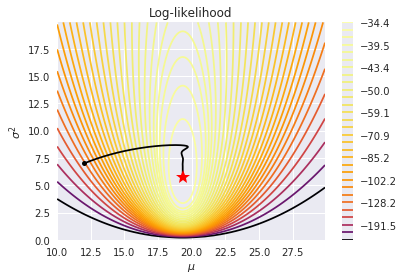

In [22]:
# Build the objective function and visualize the landscape for Gradient method
mu = np.arange(10, 30, 0.1)
var = np.arange(0.01, 20, 0.1)
theta_x, theta_y = np.meshgrid(mu, var)
theta = np.vstack((theta_x.ravel(), theta_y.ravel()))
obj = np.zeros(theta.shape[1])

def log_like(x, mu, var):
    n = len(x)
    return -1 * n / 2 * np.log(var) - 1 / 2 * np.sum((x - mu) ** 2 / var)

for i in range(theta.shape[1]):
    mu_ = theta[0, i]
    var_ = theta[1, i]
    obj[i] = log_like(data, mu_, var_)

levels = np.percentile(obj, np.linspace(8, 100, 30))
plt.contour(theta_x, theta_y, obj.reshape(theta_x.shape), levels=levels, cmap=plt.cm.get_cmap('inferno'))
plt.colorbar()
plt.plot(theta_track[0, 0], theta_track[1, 0], 'k.', markersize=10, label='Initialization')
plt.plot(theta_track[0, :], theta_track[1, :], 'k-', label='Trajectory')
plt.plot(theta_track[0, -1], theta_track[1, -1], 'r*', markersize=15, label='Convergence point')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma^2$')
plt.title('Log-likelihood')

Parameter estimation using iterative numerical method to implement MLE gives: $\mu = 19.32753, \sigma^2 = 5.75239$

### Part B: Goodness-of-fit test

Next, we could to test whether the data is really generated from the distribution:
$$f(x_{i};\theta)|_{\theta=[19.33,5.75]}=\frac{1}{\sqrt{2\pi*5.75}}e^{-\frac{(x-19.33)^{2}}{2*5.75}}$$

Frist, I'll use a QQ-plot to visualize whether the data were sampled from a Gaussian distribution.

slope=1.06, intercept=0.00, r^2=0.98


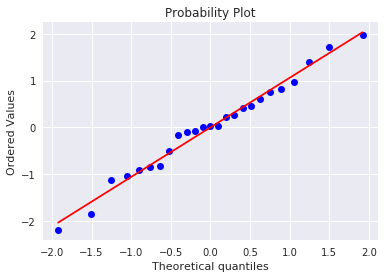

In [23]:
import scipy.stats as stats

# Calculated the z score for each data point using the estimated parameter
data_z = np.squeeze((data-theta_estimate[0])/np.sqrt(theta_estimate[1]))

_, result = stats.probplot(data_z, dist="norm", plot=plt)
print("slope=%0.2f, intercept=%0.2f, r^2=%0.2f" % (result[0],result[1], result[2] ** 2))

The linear regression of theoretical quantiles and observed values is close to diagonal.This is a good first hint that the sample was generated from a Gaussian distribution.

To do that, we develop the null hypothesis that the data is generated from the distribution $f(x_{i};\theta)|_{\theta=[19.33,5.75]}$, while the alternative hypothesis being that data were not sampled from the distribution. Given the small sample size, I will use the Lilliefors Corrected Kolmogorov-Smirnov goodness of fit test (Lilliefors's test) for short.

First, we need to construct tue test statistic $$T_{i}=\underset{x}{sup}|cdf(f(x;\theta)|_{\theta=[19.33,5.75]}),cdf(x)|$$ from the assumed population distribution. Then by referring to Critical Values for the Lilliefors Test for Normality table. We will obtain the probability that we will sample was from the assumed distribution by chance, i.e., p value.

Test statistic = 0.08


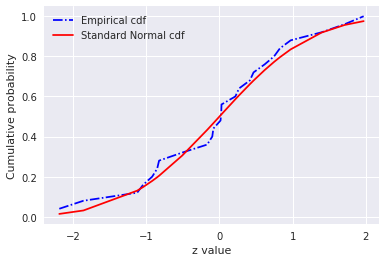

In [24]:
import statsmodels.api as sm

ecdf = sm.distributions.ECDF(data_z)
population_cdf = stats.norm.cdf(ecdf.x, loc=0, scale=1)

plt.plot(ecdf.x, ecdf.y, 'b-.', label='Empirical cdf')
plt.plot(ecdf.x, population_cdf, 'r', label='Standard Normal cdf')

T = max(abs(population_cdf - ecdf.y))
print('Test statistic = %0.2f'% (T))
plt.xlabel('z value')
plt.ylabel('Cumulative probability')
plt.legend()

Chosen type 1 error $ \alpha = 0.05$ and with sample size being 25, critical value for Lilliefors Test for Normality is 0.173. Given that our calculated test statistic T < 0.173, the null hypothesis that the data were sampled from $f(xi;θ)|_{θ=[19.33,5.75]}$ is accepted.

### Part C: MLE estimation

The MLE estimator for mean and varaince Gaussian distribution are: 
$$\hat{\theta}=\bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_{i}$$
$$\hat{\sigma^{2}}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}$$
Therefore we have

In [25]:
theta_mle = np.zeros((2,1))
theta_mle[0] = np.mean(data)
theta_mle[1] = np.mean((data - theta_mle[0])**2)
print('mean = %0.5f, variance = %0.5f' % (theta_mle[0][0], theta_mle[1][0]))

mean = 19.32753, variance = 5.75239


### PartD: MOM estimation

The MLE estimator for mean and varaince Gaussian distribution are: 
$$\hat{\theta}=\bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_{i}$$
$$\hat{\sigma^{2}}=\frac{1}{n}\sum_{i=1}^{n}x_{i}^{2}-\bar{x}{}^{2}$$
Therefore we have

In [26]:
theta_mom = np.zeros((2,1))
theta_mom[0] = np.mean(data)
theta_mom[1] = np.mean((data**2)) - theta_mle[0] ** 2
print('mean = %0.5f, variance = %0.5f' % (theta_mom[0][0], theta_mom[1][0]))

mean = 19.32753, variance = 5.75239


### Part E: Confidence Interval

Given that with mean of samples from normal distribution could be approximated by $N(\mu, s^2/n)$, 
95% confidence interval of mean estimation could be computed as $[\bar{x}+Z_{0.05} * s/\sqrt{n},\bar{x}+Z_{0.95} * s/\sqrt{n}]$. However, this works for large dataset(n > 30). In our given case, we will use Student's t-distribution to replace z, with the interval $$[\bar{x}-t_{0.975,24} * s/\sqrt{n},\bar{x}+t_{0.975, 24} * s/\sqrt{n}]$$

In [27]:
from scipy.stats import t
ste = np.sqrt(theta_mle[1] / len(data))
df = len(data) - 1
t_score = t.isf(q=0.025, df=df)
CI_mean_low = theta_mle[0] - t_score * ste
CI_mean_high = theta_mle[0] + t_score * ste

In [28]:
print('95%% confidence interval of mean is [%0.5f, %0.5f]'% (CI_mean_low, CI_mean_high))

95% confidence interval of mean is [18.33751, 20.31754]


Given the estimation of population variance as $s^2$, as $\frac{(n-1)s^{2}}{\sigma^{2}}\sim\chi^{2}(n-1)$, the confidence interval of variance could be estimated as:

$$\frac{(n-1)s^{2}}{\chi_{0.05,df=n-1}^{2}}\leq\sigma^{2}\leq\frac{(n-1)s^{2}}{\chi_{0.95,df=n-1}^{2}}$$

In [29]:
from scipy.stats import chi2

df = len(data) - 1
chi_high = chi2.isf(q=0.025, df=df)
chi_low = chi2.isf(q=0.975, df=df)

CI_var_low = theta_mle[1] * (df) / chi_high
CI_var_high = theta_mle[1] * (df) / chi_low

In [31]:
print('95%% confidence interval of variance is [%0.5f, %0.5f]'% (CI_var_low, CI_var_high))

95% confidence interval of variance is [3.50719, 11.13263]


From the above results we can say that using the obtained sample, we are 95% confident that the true mean of the population is between [18.33751, 20.31754], and 95% confident that the true variance of the data is between [3.50719, 11.13263]